# Can we beat the odds?

## Preliminaries

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import  cross_val_score

d:\users\lchan\documents\shelling-ford\venv\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
d:\users\lchan\documents\shelling-ford\venv\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, LeakyReLU, Dropout, Conv1D, MaxPool1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import metrics

Using TensorFlow backend.


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## General Settings

In [5]:
data_path = '../data/'

## HKRacing
This section contains code related to the dataset hkracing (https://www.kaggle.com/gdaley/hkracing/)

### Data Import

In [6]:
data_subdomain = 'hkracing/'

df_races = pd.read_csv(data_path + data_subdomain + 'races.csv', date_parser=['date'])
df_runs = pd.read_csv(data_path + data_subdomain + 'runs.csv')

### Data Proprocessing

In [130]:
df_races['horse_ratings_lower'] = df_races['horse_ratings'].str.split('-').str[0]
df_races['horse_ratings_upper'] = df_races['horse_ratings'].str.split('-').str[1]

df_runs['weight_difference'] = df_runs['declared_weight'] - df_runs['actual_weight']
df_runs['weight_difference_percentage'] = df_runs['weight_difference'] / df_runs['actual_weight']

df_runs['result_encoded'] = 3
df_runs.loc[df_runs['result'] == 1, 'result_encoded'] = 1
df_runs.loc[df_runs['result'] == 2, 'result_encoded'] = 1

In [131]:
df_all = df_runs.merge(df_races, left_on='race_id', right_on='race_id', how='inner')
df_all['prize'].fillna(0, inplace=True)

In [132]:
df_race_agg = df_all.groupby('race_id').agg({
    'horse_id': 'count',
    'horse_age': ['mean', 'std'],
    'horse_rating': ['mean', 'std'],
    'declared_weight': ['mean', 'std'],
    'actual_weight': ['mean', 'std'],
    'weight_difference': ['mean', 'std'],
    'weight_difference_percentage': ['mean', 'std']
}).reset_index()

df_race_agg.columns = [
    'race_id', 
    'horse_count',
    'horse_age_mean',
    'horse_age_std',
    'horse_rating_mean',
    'horse_rating_std',
    'declared_weight_mean',
    'declared_weight_std',
    'actual_weight_mean',
    'actual_weight_std',
    'weight_difference_mean',
    'weight_difference_std',
    'weight_difference_percentage_mean',
    'weight_difference_percentage_std'
]

df_all = df_all.merge(df_race_agg, left_on='race_id', right_on='race_id', how='inner')

In [133]:
df_runs.columns

Index(['race_id', 'horse_no', 'horse_id', 'result', 'won', 'lengths_behind',
       'horse_age', 'horse_country', 'horse_type', 'horse_rating',
       'horse_gear', 'declared_weight', 'actual_weight', 'draw',
       'position_sec1', 'position_sec2', 'position_sec3', 'position_sec4',
       'position_sec5', 'position_sec6', 'behind_sec1', 'behind_sec2',
       'behind_sec3', 'behind_sec4', 'behind_sec5', 'behind_sec6', 'time1',
       'time2', 'time3', 'time4', 'time5', 'time6', 'finish_time', 'win_odds',
       'place_odds', 'trainer_id', 'jockey_id', 'weight_difference',
       'weight_difference_percentage', 'result_encoded'],
      dtype='object')

In [134]:
jockeys = list(df_all['jockey_id'].unique())

df_jockeys = None

for jockey in jockeys:
    
    df_jockey = df_all[df_all['jockey_id'] == jockey].sort_values(by=['date', 'race_no'])
    df_jockey['jockey_win_rate_5'] = np.where(df_jockey['result'] < 3, 1, 0)
    df_jockey['jockey_win_rate_5'] = df_jockey['jockey_win_rate_5'].rolling(5).sum() / 5
    df_jockey['jockey_horse_age_5'] = df_jockey['horse_age'].rolling(5).mean()
    df_jockey['jockey_horse_rating_5'] = df_jockey['horse_rating'].rolling(5).mean()
    df_jockey['jockey_weight_difference_percentage_5'] = df_jockey['weight_difference_percentage'].rolling(5).mean()
    df_jockey = df_jockey[
        [
            'race_id', 'jockey_id', 'jockey_win_rate_5', 'jockey_horse_age_5', 'jockey_horse_rating_5', 'jockey_weight_difference_percentage_5'
        ]
    ]
    df_jockey.dropna(inplace=True)
    
    if df_jockeys is None:
        
        df_jockeys = df_jockey
        
    else:
        
        df_jockeys = df_jockeys.append(df_jockey)
    
    
df_jockeys

,race_id,jockey_id,jockey_win_rate_5,jockey_horse_age_5,jockey_horse_rating_5,jockey_weight_difference_percentage_5
56,4,2,0.4,3.0,60.0,7.689686
68,5,2,0.4,3.0,60.0,7.874649
94,7,2,0.2,3.0,60.0,7.857398
110,8,2,0.2,3.0,60.0,7.987044
127,9,2,0.0,3.0,60.0,7.595555
140,10,2,0.0,3.0,60.0,7.546435
150,11,2,0.0,3.0,60.0,7.586988
161,12,2,0.0,3.0,60.0,7.568966
175,13,2,0.2,3.0,60.0,7.506038
188,14,2,0.2,3.0,60.0,7.547627


In [135]:
horses = list(df_all['horse_id'].unique())

df_horses = None

for horse in horses:
    
    df_horse = df_all[df_all['horse_id'] == horse].sort_values(by=['date', 'race_no'])
    df_horse['horse_win_rate_5'] = np.where(df_horse['result'] < 3, 1, 0)
    df_horse['horse_win_rate_5'] = df_horse['horse_win_rate_5'].rolling(5).sum() / 5
    df_horse['horse_race_count'] = (df_horse['horse_id'] == horse).cumsum()
    df_horse['horse_horse_rating_5'] = df_horse['horse_rating'].rolling(5).mean()
    df_horse['horse_weight_difference_percentage_5'] = df_horse['weight_difference_percentage'].rolling(5).mean()
    df_horse = df_horse[
        [
            'race_id', 'horse_id', 'horse_win_rate_5', 'horse_race_count', 'horse_horse_rating_5', 'horse_weight_difference_percentage_5'
        ]
    ]
    df_horse.dropna(inplace=True)
    
    if df_horses is None:
        
        df_horses = df_horse
        
    else:
        
        df_horses = df_horses.append(df_horse)
    
    
df_horses

,race_id,horse_id,horse_win_rate_5,horse_race_count,horse_horse_rating_5,horse_weight_difference_percentage_5
2497,199,3917,0.4,5,60.0,6.791262
2961,236,3917,0.4,6,60.0,7.029842
3246,258,3917,0.4,7,60.0,7.246229
3603,286,3917,0.4,8,60.0,7.444004
3922,312,3917,0.2,9,60.0,7.611868
4261,339,3917,0.0,10,60.0,7.769979
4877,390,3917,0.0,11,60.0,7.733159
5618,452,3917,0.0,12,60.0,7.515268
6474,520,3917,0.0,13,60.0,7.311385
7038,565,3917,0.2,14,60.0,7.131214


In [136]:
trainers = list(df_all['trainer_id'].unique())

df_trainers = None

for trainer in trainers:
    
    df_trainer = df_all[df_all['trainer_id'] == trainer].sort_values(by=['date', 'race_no'])
    df_trainer['trainer_win_rate_5'] = np.where(df_trainer['result'] < 3, 1, 0)
    df_trainer['trainer_win_rate_5'] = df_trainer['trainer_win_rate_5'].rolling(5).sum() / 5
    df_trainer = df_trainer[
        [
            'race_id', 'trainer_id', 'trainer_win_rate_5'
        ]
    ]
    df_trainer.dropna(inplace=True)
    
    if df_trainers is None:
        
        df_trainers = df_trainer
        
    else:
        
        df_trainers = df_trainers.append(df_trainer)
    
    
df_trainers

,race_id,trainer_id,trainer_win_rate_5
56,4,118,0.4
68,5,118,0.4
99,7,118,0.2
110,8,118,0.2
122,9,118,0.0
161,12,118,0.0
176,13,118,0.0
188,14,118,0.0
202,15,118,0.2
207,16,118,0.2


In [137]:
df_all = df_all.merge(df_jockeys, left_on=['race_id', 'jockey_id'], right_on=['race_id', 'jockey_id'], how='inner')
df_all = df_all.merge(df_horses, left_on=['race_id', 'horse_id'], right_on=['race_id', 'horse_id'], how='inner')
df_all = df_all.merge(df_trainers, left_on=['race_id', 'trainer_id'], right_on=['race_id', 'trainer_id'], how='inner')

In [138]:
df_all.head()

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,horse_rating,...,weight_difference_percentage_std,jockey_win_rate_5,jockey_horse_age_5,jockey_horse_rating_5,jockey_weight_difference_percentage_5,horse_win_rate_5,horse_race_count,horse_horse_rating_5,horse_weight_difference_percentage_5,trainer_win_rate_5
0,94,5,876,9,0.0,3.75,3,NZ,Gelding,60,...,0.552276,0.0,3.0,60.0,7.563337,0.0,5,60.0,8.069224,0.0
1,116,11,550,9,0.0,5.00,3,USA,Gelding,60,...,0.761101,0.0,3.0,60.0,8.547707,0.0,5,60.0,8.440906,0.0
2,119,5,1853,3,0.0,3.00,3,SAF,Gelding,60,...,0.706870,0.4,3.0,60.0,7.578946,0.0,5,60.0,7.735458,0.0
3,119,9,876,13,0.0,13.00,3,NZ,Gelding,60,...,0.706870,0.0,3.0,60.0,7.840423,0.0,6,60.0,8.082676,0.4
4,119,9,876,13,0.0,13.00,3,NZ,Gelding,60,...,0.706870,0.0,3.0,60.0,7.840423,0.0,6,60.0,8.082676,0.4


In [139]:
for t in df_all.horse_type.unique():
    
    df_all['horse_type_' + t.lower()] = np.where(df_all['horse_type'] == t, 1, 0)
    
for t in df_all.horse_country.unique():
    
    df_all['horse_country_' + t.lower()] = np.where(df_all['horse_country'] == t, 1, 0)
    
for t in df_all.venue.unique():
    
    df_all['venue_' + t.lower()] = np.where(df_all['venue'] == t, 1, 0)
    
for t in df_all.surface.unique():
    
    df_all['surface_' + str(t).lower()] = np.where(df_all['surface'] == t, 1, 0)
    
for t in df_all.horse_gear.unique():
    
    df_all['horse_gear_' + t.lower()] = np.where(df_all['horse_gear'] == t, 1, 0)
    
df_all['going_good'] = np.where(df_all['going'].str.contains('GOOD'), 1, 0)
df_all['going_firm'] = np.where(df_all['going'].str.contains('FIRM'), 1, 0)
df_all['going_fast'] = np.where(df_all['going'].str.contains('FAST'), 1, 0)
df_all['going_yielding'] = np.where(df_all['going'].str.contains('YIELDING'), 1, 0)
df_all['going_soft'] = np.where(df_all['going'].str.contains('SOFT'), 1, 0)
df_all['going_slow'] = np.where(df_all['going'].str.contains('SLOW'), 1, 0)

In [140]:
df_all.columns

Index(['race_id', 'horse_no', 'horse_id', 'result', 'won', 'lengths_behind',
       'horse_age', 'horse_country', 'horse_type', 'horse_rating',
       ...
       'horse_gear_cp-/p2', 'horse_gear_tt/xb/v2', 'horse_gear_tt1/xb-/h/b1',
       'horse_gear_v-/xb1/b2/h2', 'going_good', 'going_firm', 'going_fast',
       'going_yielding', 'going_soft', 'going_slow'],
      dtype='object', length=874)

#### KERAS MODEL 1
This model attempts to predict the finishing position (top 2 are the ones of interest).
However, the best that I can get so far is at 16% which is only slightly better than guessing the winning pair.

In [141]:
df_keras = df_all.drop(
    [
        'race_id', 'horse_no', 'horse_id', 'won', 'jockey_id', 'trainer_id',
        'horse_age', 'horse_country', 'horse_type', 'horse_rating', 'horse_gear', 
        'declared_weight', 'actual_weight', 'position_sec1', 'position_sec2',
        'position_sec3', 'position_sec4', 'position_sec5', 'position_sec6',
        'behind_sec1', 'behind_sec2', 'behind_sec3', 'behind_sec4', 'behind_sec5', 
        'behind_sec6', 'time1_x', 'time2_x', 'time3_x', 'time4_x', 'time5_x', 
        'time6_x', 'finish_time', 'venue', 'race_no', 'result', 'date', 'config', 
        'going', 'sec_time1', 'sec_time2', 'sec_time3', 'sec_time4', 'sec_time5', 
        'sec_time6', 'sec_time7', 'time1_y', 'time2_y', 'time3_y', 'time4_y', 
        'time5_y', 'time6_y', 'time7', 'place_combination1', 'place_combination2',
        'place_combination3', 'place_combination4', 'place_dividend1',
        'place_dividend2', 'place_dividend3', 'place_dividend4',
        'win_combination1', 'win_dividend1', 'win_combination2',
        'win_dividend2', 'lengths_behind', 'place_odds', 'horse_ratings_lower', 
        'horse_ratings_upper', 'horse_ratings'
    ], 
    axis=1)
df_keras.columns

Index(['draw', 'win_odds', 'weight_difference', 'weight_difference_percentage',
       'result_encoded', 'surface', 'distance', 'prize', 'race_class',
       'horse_count',
       ...
       'horse_gear_cp-/p2', 'horse_gear_tt/xb/v2', 'horse_gear_tt1/xb-/h/b1',
       'horse_gear_v-/xb1/b2/h2', 'going_good', 'going_firm', 'going_fast',
       'going_yielding', 'going_soft', 'going_slow'],
      dtype='object', length=805)

In [142]:
df_keras.columns[list(df_keras.isnull().any())]

Index([], dtype='object')

In [143]:
model = Sequential()
model.add(Dense(128, 
                  input_shape=(len(df_keras.columns) - 1,), 
                  activation=None))
# model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.1))

# model.add(Dense(256, activation=None))
# model.add(LeakyReLU(alpha=0.3))
# model.add(Dropout(0.1))

model.add(Dense(256, activation='relu'))
# model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
# model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.1))

model.add(Dense(1, activation=None))
model.add(Activation('sigmoid'))

model.compile(optimizer=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              loss='binary_crossentropy',
              metrics=[metrics.binary_accuracy])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 128)               103040    
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 129       
__________

In [144]:
Y = df_keras['result_encoded']
X = df_keras.drop('result_encoded', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [145]:
save_model_name = "keiba_model_g2.h5"
checkpointer = ModelCheckpoint(filepath='../results/'+save_model_name, verbose=0)

model.fit(x=X_train, 
          y=y_train, 
          batch_size=64, 
          epochs=10, 
          verbose=1, 
          callbacks=[checkpointer],
          validation_split=0.2,
          shuffle=True)

Train on 52252 samples, validate on 13064 samples
Epoch 1/10
52252/52252 [==============================] - 9s 172us/step - loss: -23.9499 - binary_accuracy: 0.1568 - val_loss: -26.4885 - val_binary_accuracy: 0.1692
Epoch 2/10
52252/52252 [==============================] - 8s 150us/step - loss: -26.6723 - binary_accuracy: 0.1632 - val_loss: -26.4885 - val_binary_accuracy: 0.1692
Epoch 3/10
52252/52252 [==============================] - 8s 153us/step - loss: -26.6757 - binary_accuracy: 0.1632 - val_loss: -26.4885 - val_binary_accuracy: 0.1692
Epoch 4/10
52252/52252 [==============================] - 8s 150us/step - loss: -26.6769 - binary_accuracy: 0.1632 - val_loss: -26.4885 - val_binary_accuracy: 0.1692
Epoch 5/10
52252/52252 [==============================] - 8s 155us/step - loss: -26.6711 - binary_accuracy: 0.1632 - val_loss: -26.4885 - val_binary_accuracy: 0.1692
Epoch 6/10
52252/52252 [==============================] - 9s 164us/step - loss: -26.6764 - binary_accuracy: 0.1632 - val

#### KERAS MODEL 2
This model attempts to predict the finishing position (top 3 are the ones of interest).
However, the best that I can get so far is < 30% which is only slightly better than guessing the winning trio.

In [148]:
df_keras_2 = df_all.drop(
    [
        'race_id', 'horse_no', 'horse_id', 'won', 'jockey_id', 'trainer_id',
        'horse_age', 'horse_country', 'horse_type', 'horse_rating', 'horse_gear', 
        'declared_weight', 'actual_weight', 'position_sec1', 'position_sec2',
        'position_sec3', 'position_sec4', 'position_sec5', 'position_sec6',
        'behind_sec1', 'behind_sec2', 'behind_sec3', 'behind_sec4', 'behind_sec5', 
        'behind_sec6', 'time1_x', 'time2_x', 'time3_x', 'time4_x', 'time5_x', 
        'time6_x', 'finish_time', 'venue', 'race_no', 'date', 'config', 
        'going', 'sec_time1', 'sec_time2', 'sec_time3', 'sec_time4', 'sec_time5', 
        'sec_time6', 'sec_time7', 'time1_y', 'time2_y', 'time3_y', 'time4_y', 
        'time5_y', 'time6_y', 'time7', 'place_combination1', 'place_combination2',
        'place_combination3', 'place_combination4', 'place_dividend1',
        'place_dividend2', 'place_dividend3', 'place_dividend4',
        'win_combination1', 'win_dividend1', 'win_combination2',
        'win_dividend2', 'lengths_behind', 'place_odds', 'horse_ratings_lower', 
        'horse_ratings_upper', 'horse_ratings'
    ], 
    axis=1)

df_keras_2['result_encoded'] = 4
df_keras_2.loc[df_runs['result'] < 4, 'result_encoded'] = 1
# df_keras_2.loc[df_runs['result'] == 2, 'result_encoded'] = 1

df_keras_2.drop('result', axis=1, inplace=True)

In [154]:
model = Sequential()
model.add(Dense(128, 
                  input_shape=(len(df_keras_2.columns) - 1,), 
                  activation=None))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.1))

# model.add(Dense(256, activation=None))
model.add(LeakyReLU(alpha=0.3))
# model.add(Dropout(0.1))

model.add(Dense(256, activation='relu'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.1))

model.add(Dense(1, activation=None))
model.add(Activation('sigmoid'))

model.compile(optimizer=Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              loss='binary_crossentropy',
              metrics=[metrics.binary_accuracy])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 128)               103040    
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 128)               0         
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 256)               0         
__________

In [150]:
Y = df_keras_2['result_encoded']
X = df_keras_2.drop('result_encoded', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [155]:
save_model_name = "keiba_model_g2.h5"
checkpointer = ModelCheckpoint(filepath='../results/'+save_model_name, verbose=0)

model.fit(x=X_train, 
          y=y_train, 
          batch_size=64, 
          epochs=10, 
          verbose=1, 
          callbacks=[checkpointer],
          validation_split=0.2,
          shuffle=True)

Train on 52252 samples, validate on 13064 samples
Epoch 1/10
52252/52252 [==============================] - 11s 211us/step - loss: -2.9451 - binary_accuracy: 0.1509 - val_loss: -36.4708 - val_binary_accuracy: 0.2374
Epoch 2/10
52252/52252 [==============================] - 9s 172us/step - loss: -35.1608 - binary_accuracy: 0.2379 - val_loss: -36.4708 - val_binary_accuracy: 0.2374
Epoch 3/10
52252/52252 [==============================] - 10s 189us/step - loss: -35.7850 - binary_accuracy: 0.2395 - val_loss: -36.4708 - val_binary_accuracy: 0.2374
Epoch 4/10
52252/52252 [==============================] - 11s 213us/step - loss: -36.1743 - binary_accuracy: 0.2407 - val_loss: -36.4708 - val_binary_accuracy: 0.2374
Epoch 5/10
52252/52252 [==============================] - 10s 200us/step - loss: -36.1763 - binary_accuracy: 0.2407 - val_loss: -36.4708 - val_binary_accuracy: 0.2374
Epoch 6/10
52252/52252 [==============================] - 9s 179us/step - loss: -36.2415 - binary_accuracy: 0.2408 - 

#### KERAS MODEL 3
This model attempts to predict the finishing time.
<br>
This approach is inspired by https://medium.com/@paulingliam/using-ml-to-predict-horse-race-time-duration-6340776536e4

In [224]:
df_keras_3 = df_all.drop(
    [
        'horse_no', 'horse_id', 'won', 'jockey_id', 'trainer_id',
        'horse_age', 'horse_country', 'horse_type', 'horse_rating', 'horse_gear', 
        'declared_weight', 'actual_weight', 'position_sec1', 'position_sec2',
        'position_sec3', 'position_sec4', 'position_sec5', 'position_sec6',
        'behind_sec1', 'behind_sec2', 'behind_sec3', 'behind_sec4', 'behind_sec5', 
        'behind_sec6', 'time1_x', 'time2_x', 'time3_x', 'time4_x', 'time5_x', 
        'time6_x', 'venue', 'race_no', 'date', 'config', 'result', 'result_encoded',
        'going', 'sec_time1', 'sec_time2', 'sec_time3', 'sec_time4', 'sec_time5', 
        'sec_time6', 'sec_time7', 'time1_y', 'time2_y', 'time3_y', 'time4_y', 
        'time5_y', 'time6_y', 'time7', 'place_combination1', 'place_combination2',
        'place_combination3', 'place_combination4', 'place_dividend1',
        'place_dividend2', 'place_dividend3', 'place_dividend4',
        'win_combination1', 'win_dividend1', 'win_combination2',
        'win_dividend2', 'lengths_behind', 'place_odds', 'horse_ratings_lower', 
        'horse_ratings_upper', 'horse_ratings'
    ], 
    axis=1)

In [255]:
df_keras_3.drop(df_keras_3.columns[[x.startswith('horse_gear') for x in df_keras_3.columns]], axis=1, inplace=True)
df_keras_3.drop_duplicates(inplace=True)

In [225]:
Y = df_keras_3['finish_time'].values
X = df_keras_3.drop(['finish_time', 'race_id'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

print(X_train.shape)
print(X_test.shape)

(65316, 804)
(7258, 804)


In [227]:
model = Sequential()

model.add(Dense(128, input_shape=(len(df_keras_3.columns) - 2,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation=None))
model.add(Activation('sigmoid'))

model.compile(optimizer=Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              loss='mse')

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 128)               103040    
_________________________________________________________________
dropout_51 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_52 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_53 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 129       
__________

In [216]:
save_model_name = "keiba_model_g2.h5"
checkpointer = ModelCheckpoint(filepath='../results/'+save_model_name, verbose=0)

model.fit(x=X_train, 
          y=y_train, 
          batch_size=64, 
          epochs=10, 
          verbose=1, 
          callbacks=[checkpointer],
          validation_split=0.2,
          shuffle=True)

Train on 52252 samples, validate on 13064 samples
Epoch 1/10
52252/52252 [==============================] - 6s 113us/step - loss: 7921.9628 - val_loss: 7817.6774
Epoch 2/10
52252/52252 [==============================] - 4s 85us/step - loss: 7866.5099 - val_loss: 7817.6774
Epoch 3/10
52252/52252 [==============================] - 5s 91us/step - loss: 7851.9955 - val_loss: 7817.6774
Epoch 4/10
52252/52252 [==============================] - 4s 85us/step - loss: 7835.6014 - val_loss: 7817.6774
Epoch 5/10
52252/52252 [==============================] - 5s 87us/step - loss: 7829.9770 - val_loss: 7817.6774
Epoch 6/10
52252/52252 [==============================] - 5s 88us/step - loss: 7828.5510 - val_loss: 7817.6774
Epoch 7/10
52252/52252 [==============================] - 5s 88us/step - loss: 7825.4812 - val_loss: 7817.6774
Epoch 8/10
52252/52252 [==============================] - 5s 88us/step - loss: 7823.1469 - val_loss: 7817.6774
Epoch 9/10
52252/52252 [==============================] - 5s 

In [204]:
print(X_test.shape)
model.predict(X_test).shape

(7258, 64)


(7258, 1)

In [203]:
np.array(y_test)

array([ 97.32, 103.68,  68.87, ...,  99.3 , 100.19,  71.04])

In [205]:
y_pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

#### RANDOM FOREST
Because the above is not working

In [217]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [346]:
df_rf_fit = df_keras_3[:int(len(df_keras_3) * 0.8)]
df_rf_walk = df_keras_3[int(len(df_keras_3) * 0.8):]

Y = df_rf_fit['finish_time'].values
X = df_rf_fit.drop(['finish_time', 'race_id'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [347]:
forest = RandomForestRegressor(n_estimators=100)
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [348]:
y_pred = forest.predict(X_test)

In [349]:
y_pred

array([ 83.1807, 101.6294, 112.284 , ...,  70.6739, 101.9711,  97.8268])

In [350]:
forest_score = round(forest.score(X_test, y_test) * 100, 2)
print(forest_score)

99.8


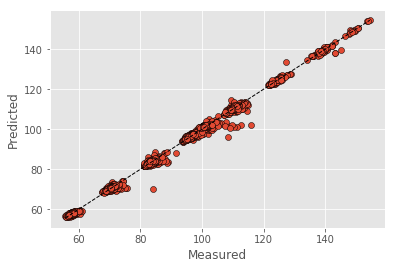

In [351]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [352]:
races = (df_rf_walk.groupby('race_id').agg({'race_id': 'count'}) > 10).index.tolist()

In [290]:
race = races[-1]

In [323]:
trial = df_keras_3[df_keras_3['race_id'] == race]

In [325]:
trial.horse_count

41220    12
41221    12
41222    12
41223    12
41224    12
41225    12
41226    12
41227    12
41228    12
41229    12
41230    12
Name: horse_count, dtype: int64

In [292]:
Y_trial = trial['finish_time'].values
X_trial = trial.drop(['finish_time', 'race_id'], axis=1)

In [293]:
X_trial

,draw,win_odds,weight_difference,weight_difference_percentage,surface,distance,prize,race_class,horse_count,horse_age_mean,...,venue_hv,venue_st,surface_0,surface_1,going_good,going_firm,going_fast,going_yielding,going_soft,going_slow
72562,9,29.0,873.0,6.664122,0,1600,1750000.0,2,14,4.071429,...,0,1,1,0,1,0,0,0,0,0
72563,10,25.0,1088.0,8.369231,0,1600,1750000.0,2,14,4.071429,...,0,1,1,0,1,0,0,0,0,0
72565,3,46.0,1043.0,8.085271,0,1600,1750000.0,2,14,4.071429,...,0,1,1,0,1,0,0,0,0,0
72566,14,1.6,1019.0,7.960938,0,1600,1750000.0,2,14,4.071429,...,0,1,1,0,1,0,0,0,0,0
72567,7,84.0,1023.0,8.055118,0,1600,1750000.0,2,14,4.071429,...,0,1,1,0,1,0,0,0,0,0
72568,11,36.0,1028.0,8.158730,0,1600,1750000.0,2,14,4.071429,...,0,1,1,0,1,0,0,0,0,0
72569,11,36.0,1028.0,8.158730,0,1600,1750000.0,2,14,4.071429,...,0,1,1,0,1,0,0,0,0,0
72570,8,6.8,935.0,7.480000,0,1600,1750000.0,2,14,4.071429,...,0,1,1,0,1,0,0,0,0,0
72571,6,99.0,1069.0,8.762295,0,1600,1750000.0,2,14,4.071429,...,0,1,1,0,1,0,0,0,0,0
72572,4,99.0,951.0,7.991597,0,1600,1750000.0,2,14,4.071429,...,0,1,1,0,1,0,0,0,0,0


In [294]:
y_pred = forest.predict(X_trial)

In [295]:
y_pred - Y_trial

array([-0.1972, -0.0544,  0.0109, -0.25  , -0.163 ,  0.0311,  0.0461,
       -0.0385,  0.0176, -0.0983,  0.0658])

In [335]:
results = pd.DataFrame(y_pred, columns=['predicted_finishing_time'])

In [336]:
results = pd.concat([results, pd.DataFrame(Y_trial, columns=['actual_finishing_time'])], axis=1)

In [337]:
results = results.sort_values(by='predicted_finishing_time').reset_index(drop=True).reset_index()
results.columns=['predicted_rank', 'predicted_finishing_time', 'actual_finishing_time']
results = results.sort_values(by='actual_finishing_time').reset_index(drop=True).reset_index()
results.columns=['actual_rank', 'predicted_rank', 'predicted_finishing_time', 'actual_finishing_time']
results

,actual_rank,predicted_rank,predicted_finishing_time,actual_finishing_time
0,0,0,70.0454,69.84
1,1,1,70.1700,70.08
2,2,2,70.1844,70.08
3,3,3,70.4143,70.28
4,4,4,70.5015,70.31
5,5,7,70.6246,70.50
6,6,5,70.5153,70.51
7,7,6,70.5435,70.59
8,8,9,70.8233,70.81
9,9,8,70.8143,70.96


In [313]:
df_keras_3['win_odds']

0        20.0
1        26.0
2        11.0
3        31.0
5        25.0
7        17.0
8        16.0
9        26.0
10        8.2
11       57.0
13       25.0
14        9.4
16        6.2
17        7.4
18       32.0
19       27.0
20        9.9
21       13.0
22       80.0
23       12.0
24       18.0
25       13.0
26        7.7
27       44.0
28       11.0
29       11.0
30       20.0
31       14.0
32       26.0
33       18.0
         ... 
72539    51.0
72540     7.9
72541    12.0
72543    94.0
72545    86.0
72546    11.0
72547    72.0
72548     8.8
72549    14.0
72551    99.0
72553     8.2
72554    18.0
72555    99.0
72556    17.0
72557     1.6
72558    23.0
72559    99.0
72560    99.0
72561    42.0
72562    29.0
72563    25.0
72565    46.0
72566     1.6
72567    84.0
72568    36.0
72569    36.0
72570     6.8
72571    99.0
72572    99.0
72573    99.0
Name: win_odds, Length: 65626, dtype: float64

In [356]:
temp = len(races)
print(temp)
# hit = 0
balance = [0]

for race in races:
    
    trial = df_rf_walk[df_rf_walk['race_id'] == race]
    
    if len(trial) < trial['horse_count'].max():
        
        continue
        
    Y_trial = trial['finish_time'].values
    X_trial = trial.drop(['finish_time', 'race_id'], axis=1)
    y_pred = forest.predict(X_trial)
    
    results = pd.DataFrame(y_pred, columns=['predicted_finishing_time'])
    results = pd.concat([results, pd.DataFrame(Y_trial, columns=['actual_finishing_time'])], axis=1)
    results = results = pd.concat([results, trial['win_odds'].reset_index(drop=True)], axis=1)
    
    results = results.sort_values(by='predicted_finishing_time').reset_index(drop=True).reset_index()
    results.columns=['predicted_rank', 'predicted_finishing_time', 'actual_finishing_time', 'win_odds']
    results = results.sort_values(by='actual_finishing_time').reset_index(drop=True).reset_index()
    results.columns=['actual_rank', 'predicted_rank', 'predicted_finishing_time', 'actual_finishing_time', 'win_odds']
    
    odds = results[(results['predicted_rank'] == 0)]['win_odds'].values[0]
    
    if odds < 5:
        
        balance.append(balance[-1])
    
    elif len(results[(results['predicted_rank'] == 0) & (results['actual_rank'] == 0)]) == 1:
            
        balance.append(balance[-1] + 10 * odds)
        
    else:
        
        balance.append(balance[-1] - 10)
    
# print(hit, '/', (temp * 2))

1197


In [357]:
balance

[0,
 -10,
 -10,
 -20,
 -30,
 -30,
 -30,
 -30,
 -40,
 -50,
 -60,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 8.0,
 -2.0,
 -2.0,
 53.0,
 43.0,
 33.0,
 23.0,
 23.0,
 23.0,
 13.0,
 3.0,
 3.0,
 3.0,
 3.0,
 -7.0,
 -17.0,
 -17.0,
 -17.0,
 48.0,
 48.0,
 48.0,
 48.0,
 48.0,
 48.0,
 130.0,
 130.0,
 130.0,
 130.0,
 130.0,
 120.0,
 120.0,
 120.0,
 182.0,
 272.0,
 262.0,
 329.0,
 329.0,
 329.0,
 428.0,
 484.0,
 624.0,
 699.0,
 699.0,
 699.0,
 699.0,
 689.0,
 689.0,
 770.0,
 760.0,
 834.0,
 834.0,
 834.0,
 834.0,
 824.0,
 824.0,
 824.0,
 886.0,
 886.0,
 886.0,
 938.0,
 938.0,
 938.0,
 928.0,
 918.0,
 908.0,
 898.0,
 898.0,
 898.0,
 898.0,
 888.0,
 1028.0,
 1018.0,
 1094.0,
 1094.0,
 1084.0,
 1084.0,
 1074.0,
 1064.0,
 1064.0,
 1064.0,
 1054.0,
 1054.0,
 1044.0,
 1044.0,
 1044.0,
 1034.0,
 1034.0,
 1024.0,
 1024.0,
 1024.0,
 1024.0,
 1014.0,
 1014.0,
 1014.0,
 1069.0,
 1059.0,
 1136.0,
 1136.0,
 1136.0,
 1136.0,
 1136.0,
 1136.0,
 1136.0,
 1136.0,
 1126.0,
 1126.0,
 1116.0,
 1106.0,
 1106.0,
 1106.0,
 1096.0

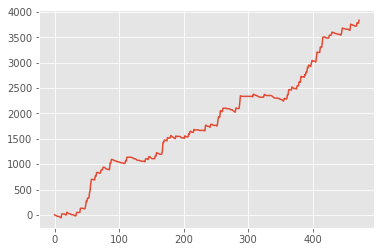

In [358]:
plt.plot(balance)